Unzip datasets and prepare data:

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from multi_imbalance.datasets import load_datasets

from multi_imbalance.resampling.spider import SPIDER3
from multi_imbalance.utils.data import construct_flat_2pc_df
import numpy as np

%matplotlib inline
sns.set_style('darkgrid')

%matplotlib inline
sns.set_style('darkgrid')

dataset = load_datasets()['new_ecoli']

X, y = dataset.data, dataset.target
print(X[:5])
print(y[:5])

[[0.49 0.29 0.48 0.5  0.56 0.24 0.35]
 [0.07 0.4  0.48 0.5  0.54 0.35 0.44]
 [0.56 0.4  0.48 0.5  0.49 0.37 0.46]
 [0.59 0.49 0.48 0.5  0.52 0.45 0.36]
 [0.23 0.32 0.48 0.5  0.55 0.25 0.35]]
[0 0 0 0 0]


In [15]:
Counter(dataset.target)

Counter({0: 145, 1: 77, 2: 37, 3: 25, 4: 52})

Resample data using SPIDER3 algorithm

In [16]:
cost = np.random.rand(64).reshape((8, 8))  # np.ones((8, 8))
for i in range(8):
    cost[i][i] = 0
    
maj_int_min = {
    'maj':[0,1],
    'int':[4],
    'min':[2,3]
}

clf = SPIDER3(k=1, maj_int_min = maj_int_min, cost=cost)
resampled_X, resampled_y = clf.fit_resample(X, y)

Compare results by plotting data in 2 dimensions

<AxesSubplot:title={'center':'Spider'}, xlabel='x1', ylabel='x2'>

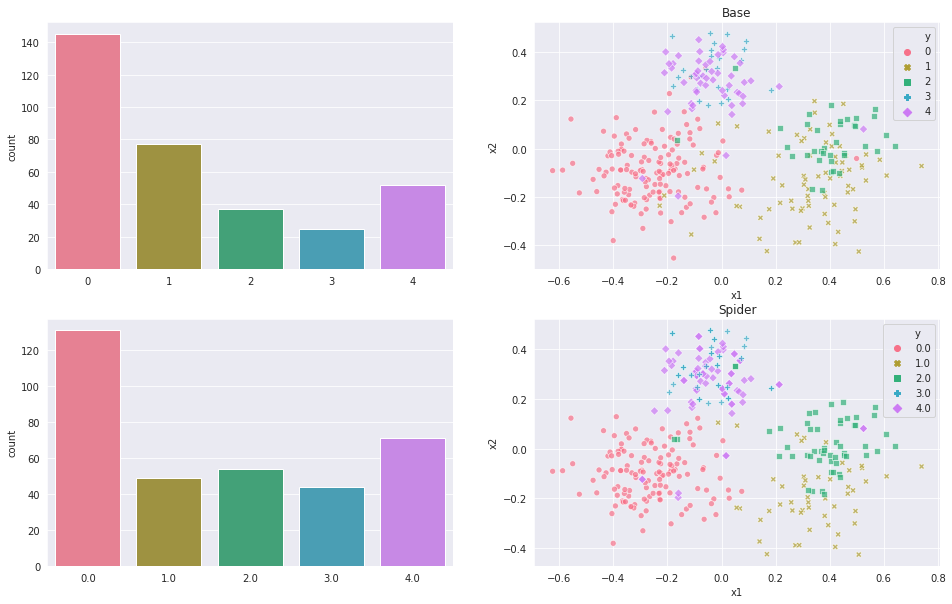

In [17]:

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches( 16, 10)
axs = axs.flatten()

axs[1].set_title("Base")
sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)


axs[3].set_title("Spider")
sns.countplot(resampled_y, ax=axs[2],palette=p)
resampled_X = pca.transform(resampled_X)
df = construct_flat_2pc_df(resampled_X, resampled_y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[3], legend='full', palette=p)

### Pipeline example

In [28]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from multi_imbalance.resampling.mdo import MDO
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report

dataset = load_datasets()['new_ecoli']

X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('spider', SPIDER3(k=1)),
    ('knn', KNN())
])
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.82      0.47      0.60        19
           2       0.44      0.70      0.54        10
           3       1.00      1.00      1.00         6
           4       0.92      0.92      0.92        13

    accuracy                           0.82        84
   macro avg       0.82      0.81      0.80        84
weighted avg       0.85      0.82      0.82        84

